Details in some calculation in our algorithm:

Step 1: Calculate H matrix:  $ H = \sum_{ \{x_i, x_j \} \in C}(x_i - x_j)(x_i - x_j)^T $
Where C denote the close set, i.e., the pair of points  are similar to each other. 


Step 2: Let $X_{\tau_{i,j},  \{x_i, x_j \} \in F} = (x_i - x_j)(x_i - x_j)^T$ 
Where F denote the Far set, i.e., the pair of points are dissimilar to each other.  In our algorithm, the far_set = close_set are just all pairs of the points in the point set. (one point denote one observation)


Calculate $\tilde{X}_{\tau_{i,j}, \{x_i, x_j \} \in F}$: $\tilde{X}_{\tau_{i,j}, \{x_i, x_j \} \in F} = H^{-\frac{1}{2}} X_{\tau_{i,j}, \{x_i, x_j \} \in F} H^{-\frac{1}{2}} \cdot \textbf{weight_function}(X,i,j)$ The weight function include: Gaussian kernel weight, laplacian kernel weight, inverse weight.



Step 3: Calculate gradient as $G = \frac{\sum_{\tau \in F} \exp(- <\tilde{X}_{\tau}, M> / \sigma)\tilde{X}_{\tau}}{\sum_{\tau \in F}\exp(- <\tilde{X}_{\tau}, M> / \sigma)}$


Then run algorithm as below:

Initialize $M_0 = I$

for t = 1,2,3, $\cdots$ T do:
    
    Calculate $G(M_{t-1})$ as in step 3
    let v_t be the maximal eigenvector of $G(M_{t-1})$
    Update M_t by M_t = (t - 1)/t * M_(t-1) + (d/t) * v_t * v_t^{T}


Return M_T






In [1]:
import plotly as plty
from plotly import express as px
from plotly import graph_objects as go
import plotly.figure_factory as ff
import pandas as pd 
cmap = px.colors.diverging.Spectral
from google.colab import drive
root = "/content/drive"
drive.mount(root)
import os 
os.chdir("/content/drive/My Drive/combustion data")
import pandas as pd 
os.chdir("PCAfold")
os.listdir()
!python setup.py build_ext --inplace
!python setup.py install
from PCAfold import PCA
from PCAfold import preprocess
from PCAfold import reduction
from PCAfold import analysis
from PCAfold import KReg

import numpy as np

import matplotlib.pyplot as plt
import pickle
import multiprocessing as multiproc

Mounted at /content/drive
running build_ext
running install
running build
running build_py
running build_ext
running install_lib
creating /usr/local/lib/python3.7/dist-packages/PCAfold
copying build/lib.linux-x86_64-3.7/PCAfold/preprocess.py -> /usr/local/lib/python3.7/dist-packages/PCAfold
copying build/lib.linux-x86_64-3.7/PCAfold/styles.py -> /usr/local/lib/python3.7/dist-packages/PCAfold
copying build/lib.linux-x86_64-3.7/PCAfold/reduction.py -> /usr/local/lib/python3.7/dist-packages/PCAfold
copying build/lib.linux-x86_64-3.7/PCAfold/analysis.py -> /usr/local/lib/python3.7/dist-packages/PCAfold
copying build/lib.linux-x86_64-3.7/PCAfold/__init__.py -> /usr/local/lib/python3.7/dist-packages/PCAfold
copying build/lib.linux-x86_64-3.7/PCAfold/kernel_regression.cpython-37m-x86_64-linux-gnu.so -> /usr/local/lib/python3.7/dist-packages/PCAfold
byte-compiling /usr/local/lib/python3.7/dist-packages/PCAfold/preprocess.py to preprocess.cpython-37.pyc
byte-compiling /usr/local/lib/python3.7/d

In [2]:
X_dict = pickle.load(open('transient-H2-air-flamelet-vars.p'         ,'rb'))
S_dict = pickle.load(open('transient-H2-air-flamelet-source-terms.p' ,'rb'))



nthSpecies = 'N2'
exclude = [nthSpecies]

varNames_full = [name for name in S_dict.keys() if name not in exclude]
X   = np.hstack([X_dict[name][None].T for name in varNames_full])
S_X = np.hstack([S_dict[name][None].T for name in varNames_full])


X, i_removed, i_retained = preprocess.remove_constant_vars(X)
S_X = S_X[:,i_retained]
varNames = list(np.array(varNames_full)[i_retained])

ncomp = 3
scaling = 'vast'
pcaObj = reduction.PCA(X, scaling=scaling, n_components=ncomp)
X_scaled = np.zeros_like(X)
S_X_scaled = np.zeros_like(X)
for i in range(X.shape[1]):
    X_scaled[:,i] = (X[:,i] - pcaObj.X_center[i])/pcaObj.X_scale[i]
    S_X_scaled[:,i] = S_X[:,i]/pcaObj.X_scale[i]

pca_x = pcaObj.transform(X_scaled)
pca_s_x = pcaObj.transform(S_X_scaled)

Below the implementation of DML algorithm

To see different shape please tune the smoothing parameter inside optimize_dml function

In [3]:
# far_set: list of list, e.g [[0,1],[1,2]] ... 
# close_set: list of list, e.g. [[2,3],[3,4]] ... 
# in this setting far_set == close_set == pairwise all points 
import numpy as np
import math
import itertools
import numba
from numba import jit,generated_jit
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from scipy.linalg import sqrtm
from sklearn import preprocessing
from tqdm import tqdm
# Generate pairwise point set by create_sub_set function as below... 
# e.g: input [1,2,3] return [[1,2],[1,3],[2,3]]
def create_sub_set(nums):
    result = []
    def dfs(res, temp, nums, index):
        if len(temp) > 2:
            return 
        if len(temp) == 2:
            res.append(list(temp))
            return 
        for i in range(index, len(nums)):
            temp.append(nums[i])
            dfs(res, temp, nums, i + 1)
            temp.pop()
    dfs(result, [], nums, 0)
    return np.array(result)


# The function to calculate outer product between i_th and j_th observation in X
@jit(nopython = True)
def calculate_outer_product(X,i,j):
    return np.outer((X[i,:] - X[j, :]), (X[i,:] - X[j, :]))

@jit(nopython = True)
def change_to_psd(m, gamma):
    value, vector = np.linalg.eig(m)
    value = np.real(value)
    vector = np.real(vector)
    value = np.maximum(value, gamma * np.ones(len(value)))
    psd_matrix = vector @ np.diag(value) @ np.linalg.inv(vector)
    return psd_matrix

# The function to calculate H matrix in step 1 
@jit(nopython = True)
def calculate_H(X, close_set, delta):
    n, d = X.shape
    result = np.zeros(shape = (d, d))
    for l in range(len(close_set)):
        i = close_set[l][0]
        j = close_set[l][1]
        result += 2 * calculate_outer_product(X,i,j)
    psd_mat = change_to_psd(result, delta)
    return psd_mat 


    # The function to calculate gradient G matrix in step 3 
# H^{-1/2} is actually calculated by cholesky decompostion of H = LL^{*} and take inverse mutiply (X[i]-X[j]), the detail can be seen in "Distance Metric Learning with Eigenvalue Optimization"
@jit(nopython=True)
def calculate_g_delta(X, W_X, far_set, sigma, M, H, b, weight_option):
    n, d = X.shape
    numerator = np.zeros(shape =(d,d))
    denominator = np.zeros(shape = (d,d))
    L = np.linalg.cholesky(H)
    H_inverse_half  = np.linalg.inv(L)
    if weight_option == "Gaussian":
      for l in range(len(far_set)):
          i = far_set[l][0]
          j = far_set[l][1]
          x_gamma_hat = H_inverse_half @ (X[i,:] - X[j, :]).reshape((d,1)) @ (X[i,:] - X[j, :]).reshape((1,d)) @ H_inverse_half.T * (1 - np.exp(-np.sum((W_X[i,:] - W_X[j,:])**2) / b**2))
          numerator += np.exp(-(np.trace(x_gamma_hat.T @ M) / sigma)) * x_gamma_hat  
          denominator += np.exp(-(np.trace(x_gamma_hat.T @ M) / sigma))
    elif weight_option == "Laplacian":
      for l in range(len(far_set)):
          i = far_set[l][0]
          j = far_set[l][1]
          x_gamma_hat = H_inverse_half @ (X[i,:] - X[j, :]).reshape((d,1)) @ (X[i,:] - X[j, :]).reshape((1,d)) @ H_inverse_half.T * (1 - np.exp(-np.linalg.norm(W_X[i,:] - W_X[j,:], ord = 1) / b**2))
          numerator += np.exp(-(np.trace(x_gamma_hat.T @ M) / sigma)) * x_gamma_hat  
          denominator += np.exp(-(np.trace(x_gamma_hat.T @ M) / sigma))
    else:
      for l in range(len(far_set)):
          i = far_set[l][0]
          j = far_set[l][1]
          x_gamma_hat = H_inverse_half @ (X[i,:] - X[j, :]).reshape((d,1)) @ (X[i,:] - X[j, :]).reshape((1,d)) @ H_inverse_half.T * (1 / max(1e-8, np.sum((W_X[i,:] - W_X[j,:])**2)**0.25))
          numerator += np.exp(-(np.trace(x_gamma_hat.T @ M) / sigma)) * x_gamma_hat  
          denominator += np.exp(-(np.trace(x_gamma_hat.T @ M) / sigma))
 
    q = numerator / denominator 
    return q 


def optimize_dml(X, W_X, b, projection_dimension, sigma, epoch = 50, column_weight = None, weight_option = None, percentile = 0.05, standardize = True, sampling_by_cluster = False, n_clusters = 2):
    """
    Input arguments: 
    X: data used to learn the transformation, usually a certain percentile, say 0.05 would be extracted from this X to learn the final transformation
    W_X: data used in weight function 
    b: the bandwidth in kernel weight or laplace weight function.
    projection_dimension: The number of projection dimensions used for the transformation. 
    epoch: the iterations for the algorithm - 1
    weight_option: Three types of weight function can be chosen: "Gaussian", "Laplacian", "Inverse"
    percentile: the percentile of the data used to learn transformation, default is 0.05 
    standardize: standardize data or not before learning transformation, default is True
    column_weight: default is None, mean column has same weight, else should be list of positive number, the length must be equal to number of column

    Return: 
    m: the transformation matrix learnt by algorithm, the dimension will be (projection_dimension, projection_dimension)
    buffer ... 
    example: 
    from sklearn import preprocesing
    m = optimize_dml(X[:,i_retained], 1e-5, 3) 
    transformed_mat = preprocessing.scale(X[:, i_retained]) @ m 
    """
    # hardcode parameters 
    n, d = X.shape
    stop_tolerance = 1e-5
    delta = 1e-5
    smooth_parameter = d * sigma

    # create the subset used in learning the transformation, based on the X and Percentile
    if sampling_by_cluster == False:
        X = X[np.arange(0, n, int(1/percentile)), :] 
        W_X = W_X[np.arange(0, n, int(1/percentile)), :]
    else:
        km =  KMeans(n_clusters=n_clusters, random_state=42).fit(X)
        l = km.labels_
        X = np.hstack((X,np.arange(X.shape[0]).reshape(X.shape[0],1)))
        _, X, _, _ = train_test_split(X, l, test_size = percentile, random_state = 42, stratify = l)
        W_X = W_X[[int(s) for s in X[:,-1]],:]
        X = X[:, :X.shape[1]-1]


    # create the far_set and close_set in data to represent pairwise similiarity 
    # currently for our algorithm, all the pairs are close_set and all the pairs are far_set. 
    close_set = create_sub_set(np.arange(0, X.shape[0]))
    far_set = create_sub_set(np.arange(0, X.shape[0]))

    # determine if the data should be standardize or not, means (x - mean(x))/sigma(x)
    if standardize == True:
        X = preprocessing.scale(X)
        #W_X = preprocessing.scale(X)

    # determine if the user-input of column weight will be applied or not. 
    if column_weight != None:
        if len(column_weight) != d:
            print("The column_weight input is incorrect \n")
            print("use default weight")
        else:
            X = X @ np.diag(column_weight)

    # calculate H matrix as in step 1 described in above cell 
    
    H = calculate_H(X, close_set, delta)
    print(np.trace(H))
    # initialize the M matrix M_0
    M = np.eye(d)
    err_buff = [] #... 
    # below is the implementation of algorithm shown in the description above this cell
    for i in tqdm(range(1, epoch)):
        # calculate gradient matrix G
        g = calculate_g_delta(X, W_X, far_set, smooth_parameter, M, H, b, weight_option)
        # find max eigenvector v_t 
        w,v = np.linalg.eig(g) 
        index_max = np.argmax(w)
        v_t = np.real(v[:, index_max])

        # update the matrix M 
        M_new = (i - 1) / i * M + (d / i) * np.outer(v_t, v_t) 
        err = (np.sum(M_new - M))**2
        print("\n")
        print("erros is ", err)
        print("\n")
        if len(err_buff) == 3:
            err_buff.pop(0)
            err_buff.append(err)
        else:
            err_buff.append(err)
        if len(err_buff) == 3 and np.mean(err_buff) <= stop_tolerance:
            print("A")
            M = M_new
            break
        else:
            M = M_new 

    # pick the top k eigenvector from M and return. 
    val, vec = np.linalg.eig(M)
    top_k_index = val.argsort()[-projection_dimension:][::-1]
    return vec[:, np.array(top_k_index)]


In [4]:
def relative_error(y_true, y_pred, tolerance):
    """
    y_true: n by 1 
    y_pred: n by 1 
    """
    r_1 = np.sqrt(np.mean(((y_true - y_pred)/ (y_true + tolerance))**2))
    #r_2 = np.sqrt(np.mean((y_true - y_pred)**2 / (y_pred + tolerance)))
    #r_3 = np.sqrt(np.mean((y_true - y_pred)**2 / (np.mean(y_true) + tolerance)))
    #r_4 = np.sqrt(np.mean((y_true - y_pred)**2 / (np.mean(y_pred) + tolerance)))
    result = {}
    result["relative_error_true"] = r_1
    #result["relative_error_pred"] = r_2
    #result["relative_error_true_mean"] = r_3
    #result["relative_error_pred_mean"] = r_4
    return result 

$$\min_{\lambda, \beta} \sum_{i = 1}^{N} ||y_i - g(X_i \beta)|| + \lambda(1 - \frac{y_i}{||y_i|||} \cdot \frac{g(x_i \beta)}{||g(x_i \beta)||})$$

In [5]:
from sklearn.kernel_ridge import KernelRidge
def run_kernel_regression(train_x, train_y, test_x, test_y, alpha, gamma):
    n_dim = train_y.shape[1]
    pred_y = np.zeros((test_y.shape[0],test_y.shape[1]))
    rmse = []
    l_inf = []
    r_2 = []
    rel_1 = []
    #clf = KernelRidge(alpha=1.0, kernel = "rbf").fit(transformed_mat[index,:], transformed_srcs[index,0])
    for i in range(n_dim):
      clf = KernelRidge(alpha=alpha, kernel = "rbf", gamma = gamma).fit(train_x, train_y[:,i])
      pred_y[:,i] = clf.predict(test_x)
      r_square = clf.score(test_x, test_y[:,i])
      r_2.append(r_square)
      rmsr = (np.sum((pred_y[:,i] - test_y[:,i])**2) / pred_y.shape[0]) ** 0.5
      rmse.append(rmsr)
      inf = np.max(np.abs(pred_y[:,i] - test_y[:,i]))
      l_inf.append(inf)
      res = relative_error(test_y[:,i], pred_y[:,i], 1e-4)
      rel_1.append(res["relative_error_true"])
    return pred_y, rmse, l_inf, r_2, rel_1

In [6]:
def same_direction(y_true, y_pred):
    """
    y_true: n by d 
    y_pred: n by d 

    """
    n = len(y_true)
    m = len(y_pred)
    count = 0 
    for i in range(n):
        count += np.dot(y_true[i,:],y_pred[i,:]) > 0 
    return count / n 

In [7]:
def cos_distance(y_true, y_pred):
    n = len(y_true)
    #m = len(y_pred)
    dist = np.zeros(n).reshape(n,1)
    for i in range(n):
        dist[i,:] = 1 - np.dot(y_true[i,:]/np.linalg.norm(y_true[i,:]),y_pred[i,:]/np.linalg.norm(y_pred[i,:]))
    return dist

In [8]:
from tabulate import tabulate 
def short_result(X, Y, P, P2, kfold, alpha, gamma, lamb = None, peak_for_all = False):
    """
    run the diagnostic on subsample
    X:  x @ M
    Y:  y @ M
    P:  percentile 

    return cv_error, r_square_value, len of list 
    """
    def my_func(a):
      return a / np.linalg.norm(a)
    d = X.shape[1]
    if lamb != None:
      X_N = np.apply_along_axis(my_func,1,X)
      X = np.hstack((X,X_N * lamb))
      Y_N = np.apply_along_axis(my_func,1,Y)
      Y = np.hstack((Y,Y_N * lamb))
      print(X.shape)
      print(Y.shape)
    """
    Generate new matrix as above 
    """

    n = X.shape[0]
    r1_index = np.random.choice(n, size = int(n * P), replace= False)
    X_1 = X[r1_index,:]
    X_2 = np.delete(X, r1_index, axis = 0)
    Y_1 = Y[r1_index, :]
    Y_2 = np.delete(Y, r1_index, axis = 0)

    random_index = np.random.choice(n, size = int(n * P2), replace= False)
    Xs = X[random_index, :]
    Ys = Y[random_index, :]


    n1 = X_1.shape[0]
    random_order = np.random.choice(n1, size = n1, replace= False)
    X_cv = X[random_order, :]
    Y_cv = Y[random_order, :]
    cv_error = {}
    cv_error["rmse " + str(kfold) + " fold AVG"] = np.zeros(Y.shape[1])
    cv_error["r_square " + str(kfold) + " fold AVG"] = np.zeros(Y.shape[1])
    cv_error["l_inf " + str(kfold) + " fold AVG"] = np.zeros(Y.shape[1])
    cv_error["relative_error_1" + str(kfold) + " fold AVG"] = np.zeros(Y.shape[1])
    cv_same_direction = 0 
    for i in tqdm(range(kfold)):
        index = [s for s in range(int(i / kfold * n1),int((i + 1)/kfold * n1))]
        X_test = X_cv[np.array(index), :]
        X_train = np.delete(X_cv, index, axis = 0)
        Y_test = Y_cv[np.array(index), :]
        Y_train = np.delete(Y_cv, index, axis = 0)
        p_y, rmse, l_inf, r_2, rel = run_kernel_regression(X_train, Y_train, X_test, Y_test, alpha, gamma)
        cv_same_direction += same_direction(Y_test[:,:d], p_y[:,:d])
        cv_error["rmse " + str(kfold) + " fold AVG"] = (cv_error["rmse " + str(kfold) + " fold AVG"] * i + np.array(rmse)) / (i + 1)
        cv_error["r_square " + str(kfold) + " fold AVG"] = (cv_error["r_square " + str(kfold) + " fold AVG"] * i + np.array(r_2)) / (i + 1)
        cv_error["l_inf " + str(kfold) + " fold AVG"] =  (cv_error["l_inf " + str(kfold) + " fold AVG"] * i + np.array(l_inf)) / (i + 1)
        cv_error["relative_error_1" + str(kfold) + " fold AVG"] =  (cv_error["relative_error_1" + str(kfold) + " fold AVG"] * i + np.array(rel)) / (i + 1)


    cv_same_direction /= kfold 
    print("The percent of same direction under cross-validation is ", cv_same_direction)
    p = pd.DataFrame(cv_error)
    print("\n")
    print("Cross-Validation Statistics of " + str(P * 100) +" percent random subsample")
    p.index = ["projected dimension " + str(i + 1) for i in range(Y.shape[1])]
    #print("\n")
    print(tabulate(p, headers = 'keys', tablefmt = 'psql'))
    print("\n")
    """
    compute peak location for subsample
    """
    bandwidth_values = np.logspace(-3.5, 0.5, 25)
    depvar_names = ['$S_{DML_' + str(i) + '}$' for i in range(Xs.shape[1])]
    variance_data = analysis.compute_normalized_variance(Xs,
                                                     Ys,
                                                     depvar_names=depvar_names,
                                                     bandwidth_values=bandwidth_values,
                                                     n_threads=4
                                                    )
    der, sig = analysis.normalized_variance_derivative(variance_data)
    print("Peak locations of the " + str(P2 * 100) +" percent random subsample")
    for depvar_name in depvar_names:
        peak_locs, peak_vals = analysis.find_local_maxima(der[depvar_name], sig, show_plot=False)
        print(depvar_name, 'peak locations:', peak_locs)
    
    if peak_for_all == True:
        """
        compute peak for all data
        """
        print("\n")
        depvar_names = ['$S_{DML_' + str(i) + '}$' for i in range(X.shape[1])]
        variance_data = analysis.compute_normalized_variance(X,
                                                     Y,
                                                     depvar_names=depvar_names,
                                                     bandwidth_values=bandwidth_values,
                                                     n_threads=4
                                                    )
        der, sig = analysis.normalized_variance_derivative(variance_data)
        print("Peak locations of the whole dataset")
        for depvar_name in depvar_names:
            peak_locs, peak_vals = analysis.find_local_maxima(der[depvar_name], sig, show_plot=False)
            print(depvar_name, 'peak locations:', peak_locs)




   
    
    
    pred, a, b, c, rel = run_kernel_regression(X_1, Y_1, X_2, Y_2, alpha, gamma)
    test_train_same_direction = same_direction(Y_2[:,:d], pred[:,:d])
    #distance = cos_distance(Y_2[:,:d], pred[:,:d])
    print("\n")
    print("Train/Test random split ratio as " + str(P * 100) + "/" + str((1- P) * 100))
    print("\n")
    print("The percent of same direction is ", test_train_same_direction)
    test_statistics = {}
    test_statistics["rmse"] = a
    test_statistics["r_square"] = c
    test_statistics["l_inf"] = b
    test_statistics["relative_error"] = rel 
    q = pd.DataFrame(test_statistics)
    q.index = ["projected dimension " + str(i + 1) for i in range(Y.shape[1])]
    print(tabulate(q, headers = 'keys', tablefmt = 'psql')) 
    return cv_error, a, b, c, pred, Y_2
        



below is the function with clustering sampling
the number cluster is 2 

Learn DML transformation use Extra Dimensions 

(Source terms, Unit vectors of Source terms)

20 Percent Train 

80 Percent Test

Stratified R2

I directly loaded the M1 matrix from My Drive

In [9]:
m1 = np.loadtxt("m1_1e-7_linear_2.csv", delimiter= ",")

In [10]:
transformed_mat = X_scaled @ m1 
transformed_srcs = S_X_scaled @ m1

In [11]:
n = transformed_mat.shape[0]
index = np.random.choice(n, size = int(n * 0.2), replace= False)
X_1 = transformed_mat[index,:]
Y_1 = transformed_srcs[index, :]
X_2 = np.delete(transformed_mat, index, axis = 0)
Y_2 = np.delete(transformed_srcs, index, axis = 0)
pred_src, rmse, l_inf, r_2, rel_1 = run_kernel_regression(X_1, Y_1, X_2, Y_2, 1e-7, 10)

findfont: Font family ['Charter'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Charter'] not found. Falling back to DejaVu Sans.
findfont: Font family ['monospace'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Charter'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Charter'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.


Bin	1	| size	 79	| R2	0.999961
Bin	2	| size	 82	| R2	0.999968
Bin	3	| size	 74	| R2	0.999959
Bin	4	| size	 70	| R2	0.999958
Bin	5	| size	 78	| R2	0.99996
Bin	6	| size	 69	| R2	0.999979
Bin	7	| size	 72	| R2	0.999988
Bin	8	| size	 76	| R2	0.999963
Bin	9	| size	 83	| R2	0.999066
Bin	10	| size	 74	| R2	0.997778
Bin	11	| size	 82	| R2	0.999654
Bin	12	| size	 87	| R2	0.99991
Bin	13	| size	 81	| R2	0.999768
Bin	14	| size	 89	| R2	0.999725
Bin	15	| size	 98	| R2	0.998284
Bin	16	| size	 156	| R2	0.99525
Bin	17	| size	 199	| R2	0.995624
Bin	18	| size	 244	| R2	0.978633
Bin	19	| size	 264	| R2	0.979999
Bin	20	| size	 289	| R2	0.975707
Bin	21	| size	 326	| R2	0.977317
Bin	22	| size	 355	| R2	0.990951
Bin	23	| size	 415	| R2	0.994714
Bin	24	| size	 487	| R2	0.993373
Bin	25	| size	 593	| R2	0.992932
Bin	26	| size	 726	| R2	0.992849
Bin	27	| size	 999	| R2	0.999754
Bin	28	| size	 1715	| R2	0.999564
Bin	29	| size	 25996	| R2	0.999812
Bin	30	| size	 1194	| R2	1.0


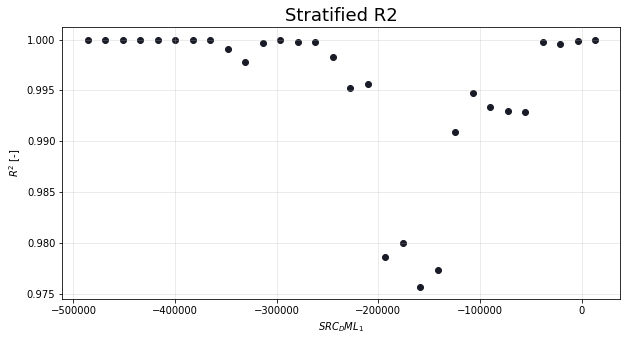

In [12]:
from PCAfold import PCA, stratified_r2, plot_stratified_r2
stra_r2, bins_borders = stratified_r2(pred_src[:,0], Y_2[:,0], 30, verbose=True)

# Visualize how R2 changes across bins:
plt = plot_stratified_r2(stra_r2, bins_borders, variable_name='$SRC_DML_1$', figure_size=(10,5), title='Stratified R2', save_filename='r2.pdf')
plt.show()
plt.close()

Bin	1	| size	 105	| R2	0.99998
Bin	2	| size	 102	| R2	0.999779
Bin	3	| size	 126	| R2	0.999725
Bin	4	| size	 133	| R2	0.998783
Bin	5	| size	 142	| R2	0.625754
Bin	6	| size	 205	| R2	0.929932
Bin	7	| size	 297	| R2	0.989195
Bin	8	| size	 369	| R2	0.995559
Bin	9	| size	 535	| R2	0.998761
Bin	10	| size	 17028	| R2	0.997973
Bin	11	| size	 7795	| R2	0.998467
Bin	12	| size	 2203	| R2	0.996655
Bin	13	| size	 1846	| R2	0.996165
Bin	14	| size	 850	| R2	0.994056
Bin	15	| size	 631	| R2	0.999213
Bin	16	| size	 498	| R2	0.999233
Bin	17	| size	 430	| R2	0.999428
Bin	18	| size	 345	| R2	0.999189
Bin	19	| size	 294	| R2	0.997307
Bin	20	| size	 226	| R2	0.999812
Bin	21	| size	 128	| R2	0.999954
Bin	22	| size	 106	| R2	0.999944
Bin	23	| size	 108	| R2	0.999984
Bin	24	| size	 111	| R2	0.999991
Bin	25	| size	 104	| R2	0.999996
Bin	26	| size	 95	| R2	0.999997
Bin	27	| size	 82	| R2	0.999992
Bin	28	| size	 92	| R2	0.999992
Bin	29	| size	 86	| R2	0.999997
Bin	30	| size	 80	| R2	1.0


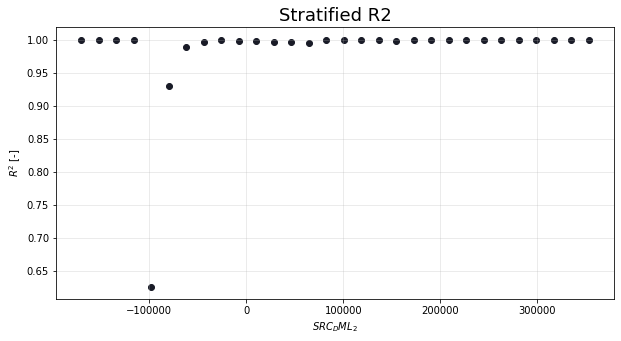

In [13]:
stra_r2, bins_borders = stratified_r2(pred_src[:,1], Y_2[:,1], 30, verbose=True)

# Visualize how R2 changes across bins:
plt = plot_stratified_r2(stra_r2, bins_borders, variable_name='$SRC_DML_2$', figure_size=(10,5), title='Stratified R2', save_filename='r2.pdf')
plt.show()
plt.close()

Bin	1	| size	 83	| R2	0.999916
Bin	2	| size	 96	| R2	0.999962
Bin	3	| size	 94	| R2	0.999932
Bin	4	| size	 93	| R2	0.999738
Bin	5	| size	 100	| R2	0.999692
Bin	6	| size	 103	| R2	0.999524
Bin	7	| size	 109	| R2	0.999582
Bin	8	| size	 124	| R2	0.995735
Bin	9	| size	 131	| R2	0.742172
Bin	10	| size	 189	| R2	0.852138
Bin	11	| size	 264	| R2	0.973905
Bin	12	| size	 333	| R2	0.98177
Bin	13	| size	 415	| R2	0.982554
Bin	14	| size	 527	| R2	0.986271
Bin	15	| size	 828	| R2	0.999196
Bin	16	| size	 2724	| R2	0.999775
Bin	17	| size	 24604	| R2	0.99978
Bin	18	| size	 1390	| R2	0.998878
Bin	19	| size	 773	| R2	0.999845
Bin	20	| size	 537	| R2	0.999591
Bin	21	| size	 402	| R2	0.993812
Bin	22	| size	 263	| R2	0.99955
Bin	23	| size	 164	| R2	0.999991
Bin	24	| size	 153	| R2	0.999985
Bin	25	| size	 131	| R2	0.999989
Bin	26	| size	 120	| R2	0.999998
Bin	27	| size	 115	| R2	0.999997
Bin	28	| size	 97	| R2	0.999996
Bin	29	| size	 100	| R2	0.999999
Bin	30	| size	 90	| R2	1.0


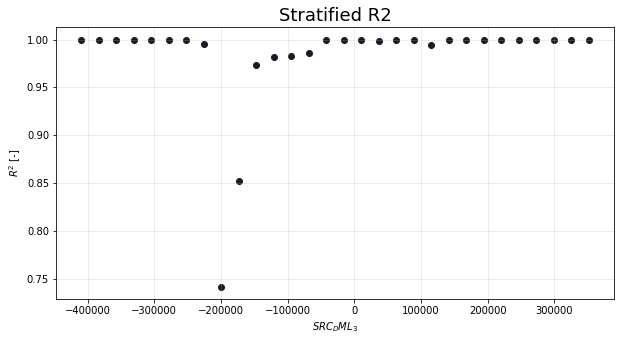

In [14]:
stra_r2, bins_borders = stratified_r2(pred_src[:,2], Y_2[:,2], 30, verbose=True)

# Visualize how R2 changes across bins:
plt = plot_stratified_r2(stra_r2, bins_borders, variable_name='$SRC_DML_3$', figure_size=(10,5), title='Stratified R2', save_filename='r2.pdf')
plt.show()
plt.close()

Draw the Cosine Distance for the whole data
And plot it

In [15]:
pred_src, rmse, l_inf, r_2, rel_1 = run_kernel_regression(X_1, Y_1, transformed_mat, transformed_srcs, 1e-7, 10)
dis = cos_distance(transformed_srcs,pred_src)

In [ ]:
cmap = px.colors.diverging.Spectral
# transformed_srcs = dmlVars @ np.real(m)
# transformed_mat = X_scaled @ np.real(m[:-1])

data = \
{
    'DML_1':transformed_mat[:,0],
    'DML_2':transformed_mat[:,1],
    'DML_3':transformed_mat[:,2],
    'Src DML_1': transformed_srcs[:,0],
    'Src DML_2': transformed_srcs[:,1],
    'Src DML_3': transformed_srcs[:,2],
    #'cos dis': dis,
}

# data = \
# {
#     'DML_1':transformed_mat[:,0]/(transformed_mat[:,0].max()-transformed_mat[:,0].min()),
#     'DML_2':transformed_mat[:,1]/(transformed_mat[:,1].max()-transformed_mat[:,1].min()),
#     'DML_3':transformed_mat[:,2]/(transformed_mat[:,2].max()-transformed_mat[:,2].min()),
#     'Src DML_1': transformed_srcs[:,0],
#     'Src DML_2': transformed_srcs[:,1],
#     'Src DML_3': transformed_srcs[:,2],
# }

for name in varNames : data[name] = X[:,varNames.index(name)]
data['dis'] = dis.reshape(dis.shape[0],)
    
stuffToPlot = \
{
    'O2': 'O2',
    'dis': 'cos distance',
    'T' : 'Temperature, (K)',
    'H' : 'H mass fraction',
    'Src DML_1': 'DML 1 source',
    'Src DML_2': 'DML 2 source',
    'Src DML_3': 'DML 3 source',
    #'cos dis': 'cosine distance between true and prediction',
}
for fieldName, title in stuffToPlot.items():
    p = \
    px.scatter_3d(data,
                  x='DML_1', 
                  y='DML_2', 
                  z='DML_3', 
                  color=fieldName,
                  title=title,
                 color_continuous_scale=cmap)
#     p = \
#     px.scatter(data,
#                   x='DML_1', 
#                   y='DML_2', 
#                   color=fieldName,
#                   title=title,
#                  color_continuous_scale=cmap)
    p.show()


below is w.o clustering sampling